# 도서관 이용률과 정신 건강의 상관관계 분석

---

# 1. 라이브러리 및 데이터 로드

- 도서관 데이터 출처: [국가도서관통계시스템](https://www.libsta.go.kr/statistics/public/stat)
- 인구통계 데이터 출처: [주민등록 인구통계](https://jumin.mois.go.kr/)
- 정신질환 데이터 출처: [보건의료빅데이터개방시스템](https://opendata.hira.or.kr/op/opb/selectRfrmList.do)

In [ ]:
# 라이브러리 로드

warnings.filterwarnings(action="default")

In [1]:
# 라이브러리 로드
import copy
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action="default")

In [2]:
# 1. 도서관 데이터
library = pd.read_excel("./data/2024년('23년 실적) 공공도서관 통계데이터_업로드용(2024.08.06).xlsx")

# 2. 인구통계 데이터
population = pd.read_csv("./data/202312_202312_주민등록인구및세대현황_연간.csv", encoding="cp949")

# 3. 정신건강 데이터
depression = pd.read_excel("./data/지역별 우울증 진료현황(2019년~2023년).xlsx", sheet_name="시군구별")
bipolar = pd.read_excel("./data/지역별 조울증 진료현황(2019년~2023년).xlsx", sheet_name="시군구별")
insomnia = pd.read_excel("./data/지역별 불면증 진료현황(2019년~2023년).xlsx", sheet_name="시군구별")
anxiety = pd.read_excel("./data/지역별 불안장애 진료현황(2019년~2023년).xlsx", sheet_name="시군구별")

---

# 2. 데이터 확인 및 정제

## 2-1. 도서관 데이터

In [3]:
library.head()

,번호,도서관명,구분,도서관 기본정보,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 303,Unnamed: 304,지식정보취약계층 관련 예산,Unnamed: 306,Unnamed: 307,Unnamed: 308,어린이서비스,Unnamed: 310,Unnamed: 311,Unnamed: 312
0,NaN,NaN,NaN,지역,시군구,설립주체,설립기관명,운영방식,운영기관명,분관내용,...,서비스이용건수_노인,서비스이용건수_다문화,도서관총예산,장애인 관련 예산,노인 관련 예산,다문화 관련 예산,어린이실,어린이 서비스 이용자수,어린이 자료(인쇄)수,어린이 연간 증가 자료(인쇄)수
1,합계,NaN,0,0,0,0,0,0,0,0,...,3369887,580929,1467238533,4895148,6212320,7542464,0,37555371,41344485,2375576
2,1,더불어 숲,공공(일반),대구,북구,사립,지역문화공간 더불어 숲,직영,지역문화공간 더불어 숲,본관,...,10,0,64160,800,400,0,유,1080,2760,260
3,2,제3의시간,공공(일반),서울,종로구,사립,(재)도서문화재단씨앗,직영,NaN,본관,...,0,0,971768,0,0,0,유,1549,1289,1289
4,3,가람도서관,공공(일반),경기,파주시,지자체,파주시청,위탁,느티나무재단,본관,...,2937,260,929468,0,0,0,유,80835,26946,0


### 2-1-1. 데이터 정제

In [4]:
# 컬럼 수정
library.iloc[0,:3] = library.columns[:3]
library.columns = library.iloc[0]  # 0번째 행을 컬럼으로 사용

# 불필요한 행 정리
library = library.iloc[2:]

# 인덱스 재설정
library.set_index("번호", inplace=True)

# 결과 출력
library.head(3)

,도서관명,구분,지역,시군구,설립주체,설립기관명,운영방식,운영기관명,분관내용,개관년도,...,서비스이용건수_노인,서비스이용건수_다문화,도서관총예산,장애인 관련 예산,노인 관련 예산,다문화 관련 예산,어린이실,어린이 서비스 이용자수,어린이 자료(인쇄)수,어린이 연간 증가 자료(인쇄)수
번호,,,,,,,,,,,,,,,,,,,,,
1,더불어 숲,공공(일반),대구,북구,사립,지역문화공간 더불어 숲,직영,지역문화공간 더불어 숲,본관,2008,...,10,0,64160,800,400,0,유,1080,2760,260
2,제3의시간,공공(일반),서울,종로구,사립,(재)도서문화재단씨앗,직영,NaN,본관,2023,...,0,0,971768,0,0,0,유,1549,1289,1289
3,가람도서관,공공(일반),경기,파주시,지자체,파주시청,위탁,느티나무재단,본관,2014,...,2937,260,929468,0,0,0,유,80835,26946,0


In [5]:
library.describe()

,도서관명,구분,지역,시군구,설립주체,설립기관명,운영방식,운영기관명,분관내용,개관년도,...,서비스이용건수_노인,서비스이용건수_다문화,도서관총예산,장애인 관련 예산,노인 관련 예산,다문화 관련 예산,어린이실,어린이 서비스 이용자수,어린이 자료(인쇄)수,어린이 연간 증가 자료(인쇄)수
count,1271,1271,1271,1271,1271,1220,1271,756,1271,1271,...,1271,1271,1271,1271,1271,1271,1271,1271,1271,1271
unique,1266,2,17,207,3,460,2,311,2,68,...,925,426,1266,505,565,459,3,1112,1136,970
top,느티나무도서관,공공(일반),경기,북구,지자체,경상남도교육청,직영,경상남도교육청,본관,2014,...,0,0,646335,0,0,0,유,공공(일반)에만 있는 통계항목,공공(일반)에만 있는 통계항목,공공(일반)에만 있는 통계항목
freq,2,1159,319,27,1008,27,1011,23,809,64,...,151,424,3,660,594,714,1106,112,112,112


### 2-1-2. 이용자 데이터 생성 `users`
- 도서관 이용자 수만 별도의 데이터셋으로 구성

In [6]:
# 시군구별 도서관 이용자 수
users = library.groupby(['지역', '시군구']).agg({'이용자수_도서관방문자수': 'sum'}).reset_index()

# 컬럼명 수정
users.rename(columns={"지역":"시도", "이용자수_도서관방문자수":"이용자수"}, inplace=True)

# 데이터 타입 변경
users["이용자수"] = users["이용자수"].astype(int)

users

,시도,시군구,이용자수
0,강원,강릉시,654584
1,강원,고성군,60968
2,강원,동해시,460423
3,강원,삼척시,259590
4,강원,속초시,433719
...,...,...,...
224,충북,제천시,290175
225,충북,증평군,267482
226,충북,진천군,348227
227,충북,청주시,1327224


## 2-2. 인구 데이터

In [7]:
population

,행정구역,2023년_총인구수,2023년_세대수,2023년_세대당 인구,2023년_남자 인구수,2023년_여자 인구수,2023년_남여 비율
0,서울특별시 (1100000000),"9,386,034","4,469,417",2.10,"4,540,031","4,846,003",0.94
1,서울특별시 종로구 (1111000000),"139,417","72,067",1.93,"67,306","72,111",0.93
2,서울특별시 중구 (1114000000),"121,312","64,714",1.87,"58,659","62,653",0.94
3,서울특별시 용산구 (1117000000),"213,151","107,825",1.98,"102,312","110,839",0.92
4,서울특별시 성동구 (1120000000),"277,361","133,089",2.08,"134,519","142,842",0.94
...,...,...,...,...,...,...,...
284,경상남도 거창군 (4888000000),"60,047","30,934",1.94,"29,555","30,492",0.97
285,경상남도 합천군 (4889000000),"41,203","23,939",1.72,"20,132","21,071",0.96
286,제주특별자치도 (5000000000),"675,252","313,155",2.16,"337,976","337,276",1.00
287,제주특별자치도 제주시 (5011000000),"491,654","224,433",2.19,"245,561","246,093",1.00


### 2-2-1. 행정구역 확인 및 수정

**데이터 구성 확인**

In [8]:
region = population["행정구역"].apply(lambda x : x.split(" "))
region

0            [서울특별시, , (1100000000)]
1         [서울특별시, 종로구, (1111000000)]
2          [서울특별시, 중구, (1114000000)]
3         [서울특별시, 용산구, (1117000000)]
4         [서울특별시, 성동구, (1120000000)]
                   ...              
284        [경상남도, 거창군, (4888000000)]
285        [경상남도, 합천군, (4889000000)]
286        [제주특별자치도, , (5000000000)]
287     [제주특별자치도, 제주시, (5011000000)]
288    [제주특별자치도, 서귀포시, (5013000000)]
Name: 행정구역, Length: 289, dtype: object

In [9]:
region.apply(lambda x : len(x)).describe()

count    289.000000
mean       3.110727
std        0.314338
min        3.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: 행정구역, dtype: float64

In [10]:
region.apply(lambda x : x[0]).unique()

array(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
       '세종특별자치시', '경기도', '강원특별자치도', '충청북도', '충청남도', '전라북도', '전라남도',
       '경상북도', '경상남도', '제주특별자치도'], dtype=object)

In [11]:
region.apply(lambda x : x[1]).values

array(['', '종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구', '', '중구', '서구',
       '동구', '영도구', '부산진구', '동래구', '남구', '북구', '해운대구', '사하구', '금정구',
       '강서구', '연제구', '수영구', '사상구', '기장군', '', '중구', '동구', '서구', '남구',
       '북구', '수성구', '달서구', '달성군', '군위군', '', '중구', '중구영종출장소', '중구용유출장소',
       '동구', '미추홀구', '연수구', '남동구', '부평구', '계양구', '서구', '서구검단출장소', '강화군',
       '옹진군', '', '동구', '서구', '남구', '북구', '광산구', '', '동구', '중구', '서구',
       '유성구', '대덕구', '', '중구', '남구', '동구', '북구', '울주군', '', '', '', '수원시',
       '수원시', '수원시', '수원시', '수원시', '성남시', '성남시', '성남시', '성남시', '의정부시',
       '안양시', '안양시', '안양시', '부천시', '광명시', '평택시', '송탄출장소', '안중출장소', '동두천시',
       '안산시', '안산시', '안산시', '고양시', '고양시', '고양시', '고양시', '과천시', '구리시',
       '남양주시', '풍양출장소', '오산시', '시흥시', '군포시', '의왕시', '하남시', '용인시', '용인시',
       '용인시', '용인시', '파주시', '이천시', '안성시', '김포시', '화성시', '화성시동부

In [12]:
region.apply(lambda x : x[2]).unique()

array(['(1100000000)', '(1111000000)', '(1114000000)', '(1117000000)',
       '(1120000000)', '(1121500000)', '(1123000000)', '(1126000000)',
       '(1129000000)', '(1130500000)', '(1132000000)', '(1135000000)',
       '(1138000000)', '(1141000000)', '(1144000000)', '(1147000000)',
       '(1150000000)', '(1153000000)', '(1154500000)', '(1156000000)',
       '(1159000000)', '(1162000000)', '(1165000000)', '(1168000000)',
       '(1171000000)', '(1174000000)', '(2600000000)', '(2611000000)',
       '(2614000000)', '(2617000000)', '(2620000000)', '(2623000000)',
       '(2626000000)', '(2629000000)', '(2632000000)', '(2635000000)',
       '(2638000000)', '(2641000000)', '(2644000000)', '(2647000000)',
       '(2650000000)', '(2653000000)', '(2671000000)', '(2700000000)',
       '(2711000000)', '(2714000000)', '(2717000000)', '(2720000000)',
       '(2723000000)', '(2726000000)', '(2729000000)', '(2771000000)',
       '(2772000000)', '(2800000000)', '(2811000000)', '(2811400000)',
      

- 시군구명이 2개 있는 경우가 존재함

In [13]:
# 시군구명 2개인 지역
region[region.apply(lambda x: len(x))==4]

89        [경기도, 수원시, 장안구, (4111100000)]
90        [경기도, 수원시, 권선구, (4111300000)]
91        [경기도, 수원시, 팔달구, (4111500000)]
92        [경기도, 수원시, 영통구, (4111700000)]
94        [경기도, 성남시, 수정구, (4113100000)]
95        [경기도, 성남시, 중원구, (4113300000)]
96        [경기도, 성남시, 분당구, (4113500000)]
99        [경기도, 안양시, 만안구, (4117100000)]
100       [경기도, 안양시, 동안구, (4117300000)]
108       [경기도, 안산시, 상록구, (4127100000)]
109       [경기도, 안산시, 단원구, (4127300000)]
111       [경기도, 고양시, 덕양구, (4128100000)]
112      [경기도, 고양시, 일산동구, (4128500000)]
113      [경기도, 고양시, 일산서구, (4128700000)]
124       [경기도, 용인시, 처인구, (4146100000)]
125       [경기도, 용인시, 기흥구, (4146300000)]
126       [경기도, 용인시, 수지구, (4146500000)]
162      [충청북도, 청주시, 상당구, (4311100000)]
163      [충청북도, 청주시, 서원구, (4311200000)]
164      [충청북도, 청주시, 흥덕구, (4311300000)]
165      [충청북도, 청주시, 청원구, (4311400000)]
178      [충청남도, 천안시, 동남구, (4413100000)]
179      [충청남도, 천안시, 서북구, (4413300000)]
196      [전라북도, 전주시, 완산구, (4511100000)]
197      [전라북도, 전주시, 덕진구, (4511300000)]


In [14]:
population.head(3)

,행정구역,2023년_총인구수,2023년_세대수,2023년_세대당 인구,2023년_남자 인구수,2023년_여자 인구수,2023년_남여 비율
0,서울특별시 (1100000000),"9,386,034","4,469,417",2.10,"4,540,031","4,846,003",0.94
1,서울특별시 종로구 (1111000000),"139,417","72,067",1.93,"67,306","72,111",0.93
2,서울특별시 중구 (1114000000),"121,312","64,714",1.87,"58,659","62,653",0.94


- 시도별 합계 행이 존재함
---

**행정구역 수정**
- `split(" ")`을 통해 시도, 시군구, 시군구2, 지역코드로 분리
- 지역코드 삭제

In [15]:
# 행정구역 수정
population["행정구역"] = population["행정구역"].apply(lambda x : x.split(" (")[0])

# 시도/시군구 분리
population.insert(1, "시도", population["행정구역"].apply(lambda x : x.split(" ")[0]))
population.insert(2, "시군구", population["행정구역"].apply(lambda x : x.split(" ")[1]))
population.insert(3, "시군구2", population["행정구역"].apply(lambda x : x.split(" ")[2] if len(x.split(" "))==3 else ""))

# 행정구역 컬럼 삭제
population.drop(columns="행정구역", inplace=True)

# 확인
population.head()

,시도,시군구,시군구2,2023년_총인구수,2023년_세대수,2023년_세대당 인구,2023년_남자 인구수,2023년_여자 인구수,2023년_남여 비율
0,서울특별시,,,"9,386,034","4,469,417",2.10,"4,540,031","4,846,003",0.94
1,서울특별시,종로구,,"139,417","72,067",1.93,"67,306","72,111",0.93
2,서울특별시,중구,,"121,312","64,714",1.87,"58,659","62,653",0.94
3,서울특별시,용산구,,"213,151","107,825",1.98,"102,312","110,839",0.92
4,서울특별시,성동구,,"277,361","133,089",2.08,"134,519","142,842",0.94


In [16]:
# 시도 단위 인구수 합계
population[population["시군구"]==""]

,시도,시군구,시군구2,2023년_총인구수,2023년_세대수,2023년_세대당 인구,2023년_남자 인구수,2023년_여자 인구수,2023년_남여 비율
0,서울특별시,,,"9,386,034","4,469,417",2.10,"4,540,031","4,846,003",0.94
26,부산광역시,,,"3,293,362","1,564,588",2.10,"1,605,431","1,687,931",0.95
43,대구광역시,,,"2,374,960","1,094,148",2.17,"1,166,803","1,208,157",0.97
53,인천광역시,,,"2,997,410","1,350,912",2.22,"1,499,016","1,498,394",1.00
67,광주광역시,,,"1,419,237","655,433",2.17,"700,896","718,341",0.98
73,대전광역시,,,"1,442,216","680,261",2.12,"719,292","722,924",0.99
79,울산광역시,,,"1,103,661","490,690",2.25,"567,153","536,508",1.06
85,세종특별자치시,,,"386,525","160,835",2.40,"192,524","194,001",0.99
86,세종특별자치시,,,"386,525","160,835",2.40,"192,524","194,001",0.99
87,경기도,,,"13,630,821","5,978,724",2.28,"6,855,895","6,774,926",1.01


- 세종특별자치시 : 하위 시군구가 존재하지 않아, 시군구 컬럼이 비어 있음

In [17]:
# 세종시 시군구 추가
population.loc[86, "시군구"] = "세종시"

population.iloc[85:87]

,시도,시군구,시군구2,2023년_총인구수,2023년_세대수,2023년_세대당 인구,2023년_남자 인구수,2023년_여자 인구수,2023년_남여 비율
85,세종특별자치시,,,"386,525","160,835",2.4,"192,524","194,001",0.99
86,세종특별자치시,세종시,,"386,525","160,835",2.4,"192,524","194,001",0.99


### 2-2-2. 데이터 정제

In [18]:
# 필요 컬럼만 추출
population = population.iloc[:,:4]

# 컬럼명 변경
population.rename(columns={"2023년_총인구수":"인구수"}, inplace=True)

# 인구수 컬럼 수정
population["인구수"] = population["인구수"].apply(lambda x : x.replace(",",""))

# 데이터 타입 변경
population["인구수"] = population["인구수"].astype(int)

# 확인
population

,시도,시군구,시군구2,인구수
0,서울특별시,,,9386034
1,서울특별시,종로구,,139417
2,서울특별시,중구,,121312
3,서울특별시,용산구,,213151
4,서울특별시,성동구,,277361
...,...,...,...,...
284,경상남도,거창군,,60047
285,경상남도,합천군,,41203
286,제주특별자치도,,,675252
287,제주특별자치도,제주시,,491654


## 2-3. 정신질환 데이터
- 정신질환 데이터 4종은 데이터 구성 방식이 같음
---
1. 정제함수를 만들어 일괄적으로 정제
2. 각 질환 데이터를 하나의 데이터셋으로 구성

In [19]:
# 우울증 데이터 확인
depression

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,[시군구별 우울증 진료현황],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(단위: 원, 일, 명)",NaN
3,시도,시군구,2019년,NaN,NaN,2020년,NaN,NaN,2021년,NaN,NaN,2022년,NaN,NaN,2023년,NaN,NaN
4,NaN,NaN,요양급여비용,입내원일수,환자수,요양급여비용,입내원일수,환자수,요양급여비용,입내원일수,환자수,요양급여비용,입내원일수,환자수,요양급여비용,입내원일수,환자수
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,경남,거제시,910068270,20447,2994,1009785310,25088,3527,1054718040,26475,3942,1063457770,25644,3972,1112212690,25983,4030
255,경남,양산시,1624407250,28606,4018,1998651630,32276,4465,2133126160,35703,4812,2559578320,41638,5626,2911619540,47933,5852
256,제주,서귀포시,678836010,16204,2169,699849870,16130,2217,754789270,16945,2561,803294580,17353,2659,732984430,15672,2409
257,제주,제주시,4202491830,75568,9521,4687370070,81374,9994,4319817920,79067,10446,4460008310,81068,11056,5655047750,92130,12299


### 2-3-1. 데이터 정제

In [20]:
# 정신건강 데이터 정제 함수 생성

def edit_df(raw_df):
    df = copy.deepcopy(raw_df)
    
    # 사용할 컬럼 추출
    cols = ["Unnamed: 0","Unnamed: 1","Unnamed: 16"]
    
    # 필요 데이터만 추출
    df = df.loc[5:, cols]
    
    # 컬럼명 수정
    df.columns = ["시도","시군구","환자수"]
    
    # 인덱스 초기화
    df.reset_index(drop=True, inplace=True)
    
    return df

In [21]:
# 정제 데이터 생성

anxiety = edit_df(anxiety)
bipolar = edit_df(bipolar)
depression = edit_df(depression)
insomnia = edit_df(insomnia)

In [22]:
anxiety

,시도,시군구,환자수
0,서울,강남구,20220
1,서울,강동구,10225
2,서울,강서구,9675
3,서울,관악구,8664
4,서울,구로구,7374
...,...,...,...
249,경남,거제시,3371
250,경남,양산시,4447
251,제주,서귀포시,2258
252,제주,제주시,8561


### 2-3-2. 정신질환 통합 데이터 생성 `patients`
- 정신질환 4종의 환자수를 하나의 데이터셋으로 구성

In [23]:
# 정신질환 환자수 통합 데이터 생성

# 불안장애 데이터로 기본 프레임 생성
patients = copy.deepcopy(anxiety)

# 컬럼명 변경
patients.rename(columns={"환자수":"불안장애"}, inplace=True)
patients["불안장애"] = patients["불안장애"].astype(int)

# 각 질환별 컬럼 생성
patients["조울증"] = bipolar["환자수"].astype(int)
patients["우울증"] = depression["환자수"].astype(int)
patients["불면증"] = insomnia["환자수"].astype(int)

# 확인
patients

,시도,시군구,불안장애,조울증,우울증,불면증
0,서울,강남구,20220,6440,35234,21526
1,서울,강동구,10225,1823,13938,8568
2,서울,강서구,9675,1553,12364,8930
3,서울,관악구,8664,1444,14197,6573
4,서울,구로구,7374,1560,10387,5619
...,...,...,...,...,...,...
249,경남,거제시,3371,328,4030,3328
250,경남,양산시,4447,1418,5852,5101
251,제주,서귀포시,2258,161,2409,2406
252,제주,제주시,8561,1532,12299,6224


## 2-4. 지역명 통일
- **도서관 데이터**의 지역명을 기준으로 통일
    - `시도` : 2글자로 통일
    - `시군구` : 하위 지역이 존재하더라도, 한 단계만 사용

### 2-4-1. 도서관

**시도, 시군구 개수 및 형태 확인**

In [24]:
# 시도
print("* 시도 :", users["시도"].nunique())
print(users["시도"].unique())

# 시도-시군구

print("\n* 시도-시군구 : ", len(users.groupby(["시도","시군구"]).nunique()))
print(users.groupby("시도")["시군구"].unique())

* 시도 : 17
['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

* 시도-시군구 :  229
시도
강원    [강릉시, 고성군, 동해시, 삼척시, 속초시, 양구군, 양양군, 영월군, 원주시, ...
경기    [가평군, 고양시, 과천시, 광명시, 광주시, 구리시, 군포시, 김포시, 남양주시,...
경남    [거제시, 거창군, 고성군, 김해시, 남해군, 밀양시, 사천시, 산청군, 양산시, ...
경북    [경산시, 경주시, 고령군, 구미시, 김천시, 문경시, 봉화군, 상주시, 성주군, ...
광주                                [광산구, 남구, 동구, 북구, 서구]
대구             [군위군, 남구, 달서구, 달성군, 동구, 북구, 서구, 수성구, 중구]
대전                               [대덕구, 동구, 서구, 유성구, 중구]
부산    [강서구, 금정구, 기장군, 남구, 동구, 동래구, 부산진구, 북구, 사상구, 사하...
서울    [강남구, 강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, ...
세종                                                [세종시]
울산                                [남구, 동구, 북구, 울주군, 중구]
인천     [강화군, 계양구, 남동구, 동구, 미추홀구, 부평구, 서구, 연수구, 옹진군, 중구]
전남    [강진군, 고흥군, 곡성군, 광양시, 구례군, 나주시, 담양군, 목포시, 무안군, ...
전북    [고창군, 군산시, 김제시, 남원시, 무주군, 부안군, 순창군, 완주군, 익산시, ...
제주                                          [서귀포시, 제주시]
충남    [계룡시, 공주시, 금산군, 논산시, 당진시, 보령시, 부여군, 

In [25]:
users

,시도,시군구,이용자수
0,강원,강릉시,654584
1,강원,고성군,60968
2,강원,동해시,460423
3,강원,삼척시,259590
4,강원,속초시,433719
...,...,...,...
224,충북,제천시,290175
225,충북,증평군,267482
226,충북,진천군,348227
227,충북,청주시,1327224


In [26]:
users.groupby(["시도"])["시군구"].count()

시도
강원    18
경기    31
경남    18
경북    22
광주     5
대구     9
대전     5
부산    16
서울    25
세종     1
울산     5
인천    10
전남    22
전북    14
제주     2
충남    15
충북    11
Name: 시군구, dtype: int64

In [27]:
# 시도명 리스트 생성
sido_list = sorted(users["시도"].unique())

### 2-4-2. 인구

**지역명 확인**
- 시도 : 풀네임
- 시군구 : `-출장소` 존재
- 시군구2 존재

In [28]:
# 시도
print("* 시도 :", population["시도"].nunique())
print(population["시도"].unique())

# 시도-시군구
print("\n* 시도-시군구 : ", len(population.groupby(["시도","시군구"]).nunique()))
print(population.groupby("시도")["시군구"].unique())

# 시도-시군구-시군구2
print("\n* 시도-시군구-시군구2 : ", len(population.groupby(["시도","시군구","시군구2"]).nunique()))

* 시도 : 17
['서울특별시' '부산광역시' '대구광역시' '인천광역시' '광주광역시' '대전광역시' '울산광역시' '세종특별자치시' '경기도'
 '강원특별자치도' '충청북도' '충청남도' '전라북도' '전라남도' '경상북도' '경상남도' '제주특별자치도']

* 시도-시군구 :  257
시도
강원특별자치도    [, 춘천시, 원주시, 강릉시, 동해시, 태백시, 속초시, 삼척시, 홍천군, 횡성군...
경기도        [, 수원시, 성남시, 의정부시, 안양시, 부천시, 광명시, 평택시, 송탄출장소, ...
경상남도       [, 창원시, 진주시, 통영시, 사천시, 사천남양출장소, 김해시, 장유출장소, 밀양...
경상북도       [, 포항시, 경주시, 김천시, 안동시, 구미시, 영주시, 영천시, 상주시, 문경시...
광주광역시                                [, 동구, 서구, 남구, 북구, 광산구]
대구광역시             [, 중구, 동구, 서구, 남구, 북구, 수성구, 달서구, 달성군, 군위군]
대전광역시                               [, 동구, 중구, 서구, 유성구, 대덕구]
부산광역시      [, 중구, 서구, 동구, 영도구, 부산진구, 동래구, 남구, 북구, 해운대구, 사...
서울특별시      [, 종로구, 중구, 용산구, 성동구, 광진구, 동대문구, 중랑구, 성북구, 강북구...
세종특별자치시                                              [, 세종시]
울산광역시                                [, 중구, 남구, 동구, 북구, 울주군]
인천광역시      [, 중구, 중구영종출장소, 중구용유출장소, 동구, 미추홀구, 연수구, 남동구, 부...
전라남도       [, 목포시, 여수시, 순천시, 나주시, 광양시, 담양군, 곡성군, 구례군, 고흥군...
전라북도       [, 전주시, 군산시, 익산시, 정읍시, 남원시, 김

---
**시군구**

In [29]:
# 인구 데이터에만 존재하는 시군구 확인

only_ppltn = []

# 시도명 변경
ppltn_sido = sorted(population["시도"].unique())
population["시도"] = population["시도"].replace(ppltn_sido, sido_list)

for sido in sido_list:
    users_sigungu = users.loc[users["시도"]==sido, "시군구"].unique()
    population_sigungu = population.loc[population["시도"]==sido, "시군구"].unique()
    
    # 인구 데이터에만 존재하는 시군구 리스트 생성
    temp = [sgg for sgg in population_sigungu if sgg not in users_sigungu and sgg!=""]
    
    if len(temp):
        print(f"{sido}\n{temp}\n")
        
    only_ppltn += temp

경기
['송탄출장소', '안중출장소', '풍양출장소', '화성시동부출장소', '화성시동탄출장소']

경남
['사천남양출장소', '장유출장소', '양산시웅상출장소']

인천
['중구영종출장소', '중구용유출장소', '서구검단출장소']



- 시군구명에 `출장소`가 들어간 값들이 11개 존재
- 제거해주기

---
**시군구명2**

In [30]:
# 시군구2 존재하는 지역 확인
population.groupby(["시도","시군구"])["시군구2"].unique()[
    population.groupby(["시도","시군구"])["시군구2"].nunique()>1
].to_frame()

시군구2
시도 시군구                                 
경기 고양시              [, 덕양구, 일산동구, 일산서구]
   성남시                [, 수정구, 중원구, 분당구]
   수원시           [, 장안구, 권선구, 팔달구, 영통구]
   안산시                     [, 상록구, 단원구]
   안양시                     [, 만안구, 동안구]
   용인시                [, 처인구, 기흥구, 수지구]
경남 창원시  [, 의창구, 성산구, 마산합포구, 마산회원구, 진해구]
경북 포항시                       [, 남구, 북구]
전북 전주시                     [, 완산구, 덕진구]
충남 천안시                     [, 동남구, 서북구]
충북 청주시           [, 상당구, 서원구, 흥덕구, 청원구]

In [31]:
population[population["시군구"]=="수원시"]

,시도,시군구,시군구2,인구수
88,경기,수원시,,1197257
89,경기,수원시,장안구,270849
90,경기,수원시,권선구,366167
91,경기,수원시,팔달구,197213
92,경기,수원시,영통구,363028


---
**지역명 수정**

- `시도`
    - 2글자로 통일
    - ex. 서울특별시 → 서울
- `시군구`
    - -출장소 삭제
- `시군구2` 존재하는 지역
    - 상위 지역 기준으로 통합

In [32]:
# 시도명 변경
ppltn_sido = sorted(population["시도"].unique())
population["시도"] = population["시도"].replace(ppltn_sido, sido_list)

# 시도 데이터, 시군구 데이터 분리
sido_population = population[population["시군구"]==""].copy()
sigungu_population = population[population["시군구"]!=""].copy()

# 시도 데이터 컬럼 및 정렬 수정
sido_population = sido_population[["시도","인구수"]].sort_values("시도")
sido_population.reset_index(drop=True, inplace=True)

# 시군구 데이터 수정
# 시군구2 단위는 사용하지 않음
sigungu_population = sigungu_population[sigungu_population["시군구2"]==""]
sigungu_population = sigungu_population.drop(columns="시군구2")

# 시군구명에 "출장소"가 없는 데이터만 사용
sigungu_population = sigungu_population[sigungu_population["시군구"].str.find("출장소")==-1]

# 인덱스 재설정
sigungu_population = sigungu_population.sort_values(["시도","시군구"]).reset_index(drop=True)

# 최종 데이터셋 확인
print(sido_population.shape, sigungu_population.shape)

(17, 2) (229, 3)


In [33]:
sido_population

,시도,인구수
0,강원,1527807
1,경기,13630821
2,경남,3251158
3,경북,2554324
4,광주,1419237
5,대구,2374960
6,대전,1442216
7,부산,3293362
8,서울,9386034
9,세종,386525


In [34]:
sigungu_population

,시도,시군구,인구수
0,강원,강릉시,209439
1,강원,고성군,27305
2,강원,동해시,88625
3,강원,삼척시,62651
4,강원,속초시,82054
...,...,...,...
224,충북,제천시,130194
225,충북,증평군,37484
226,충북,진천군,86254
227,충북,청주시,852189


---

### 2-4-3. 정신질환
- 시도 : 2글자
- 시군구 : 시도의 이름이 붙어있거나, 같은 시 안에서 구까지 나누는 경우가 있음

**지역명 확인**

In [35]:
# 시도
print("* 시도 :", anxiety["시도"].nunique())
print(anxiety["시도"].unique())

# 시도-시군구
print("\n* 시도-시군구 : ", len(anxiety.groupby(["시도","시군구"]).nunique()))
print(anxiety.groupby("시도")["시군구"].unique())

* 시도 : 17
['서울' '부산' '인천' '대구' '광주' '대전' '울산' '경기' '강원' '충북' '충남' '전북' '전남' '경북'
 '경남' '제주' '세종']

* 시도-시군구 :  254
시도
강원    [고성군, 양구군, 양양군, 영월군, 인제군, 정선군, 철원군, 평창군, 홍천군, ...
경기    [가평군, 양평군, 연천군, 광명시, 동두천시, 부천시, 부천소사구, 부천오정구, ...
경남    [거창군, 고성군, 남해군, 산청군, 의령군, 창녕군, 하동군, 함안군, 함양군, ...
경북    [고령군, 군위군, 봉화군, 성주군, 영덕군, 영양군, 예천군, 울릉군, 울진군, ...
광주                      [광주동구, 광주북구, 광주서구, 광주광산구, 광주남구]
대구    [대구남구, 대구동구, 대구북구, 대구서구, 대구수성구, 대구중구, 대구달서구, 대...
대전                     [대전유성구, 대전대덕구, 대전서구, 대전동구, 대전중구]
부산    [부산남구, 부산동구, 부산동래구, 부산진구, 부산북구, 부산서구, 부산영도구, 부...
서울    [강남구, 강동구, 강서구, 관악구, 구로구, 도봉구, 동대문구, 동작구, 마포구,...
세종                                                [세종시]
울산                      [울산남구, 울산동구, 울산중구, 울산북구, 울산울주군]
인천    [인천미추홀구, 인천동구, 인천부평구, 인천중구, 인천서구, 인천남동구, 인천연수구...
전남    [강진군, 고흥군, 곡성군, 구례군, 담양군, 무안군, 보성군, 신안군, 영광군, ...
전북    [고창군, 무주군, 부안군, 순창군, 완주군, 임실군, 장수군, 진안군, 군산시, ...
제주                                          [서귀포시, 제주시]
충남    [금산군, 부여군, 서천군, 예산군, 청양군, 홍성군, 태안군, 

- 구 이름 중복되는 경우가 있어서 시도명을 붙여서 만든 것 같음

In [36]:
# 시군구 전체 데이터 확인
anxiety.groupby("시도")["시군구"].unique().to_list()

[array(['고성군', '양구군', '양양군', '영월군', '인제군', '정선군', '철원군', '평창군', '홍천군',
        '화천군', '횡성군', '강릉시', '동해시', '속초시', '원주시', '춘천시', '태백시', '삼척시'],
       dtype=object),
 array(['가평군', '양평군', '연천군', '광명시', '동두천시', '부천시', '부천소사구', '부천오정구',
        '부천원미구', '성남수정구', '성남중원구', '성남분당구', '수원권선구', '수원장안구', '수원팔달구',
        '수원영통구', '안양만안구', '안양동안구', '의정부시', '과천시', '구리시', '안산단원구', '안산상록구',
        '평택시', '하남시', '군포시', '남양주시', '의왕시', '시흥시', '오산시', '고양덕양구',
        '고양일산서구', '고양일산동구', '용인기흥구', '용인수지구', '용인처인구', '이천시', '파주시', '김포시',
        '안성시', '화성시', '광주시', '양주시', '포천시', '여주시'], dtype=object),
 array(['거창군', '고성군', '남해군', '산청군', '의령군', '창녕군', '하동군', '함안군', '함양군',
        '합천군', '김해시', '사천시', '진주시', '창원마산회원구', '창원마산합포구', '창원진해구', '창원의창구',
        '창원성산구', '통영시', '밀양시', '거제시', '양산시'], dtype=object),
 array(['고령군', '군위군', '봉화군', '성주군', '영덕군', '영양군', '예천군', '울릉군', '울진군',
        '의성군', '청도군', '청송군', '칠곡군', '경주시', '구미시', '김천시', '안동시', '영주시',
        '영천시', '포항남구', '포항북구', '문경시', '상주시', '경산시'], dtype=ob

---
**예외 지역 확인**

**1. 부천시**
- 부천시는 소사구/오정구/원미구 3개의 구로 나뉘지만, 3개 하위구의 합과 부천시의 합계가 일치하지 않음

In [37]:
anxiety[(anxiety["시군구"].str.startswith("부천"))]

,시도,시군구,환자수
80,경기,부천시,14028
81,경기,부천소사구,1411
82,경기,부천오정구,474
83,경기,부천원미구,3684


[데이터 수집기준]								
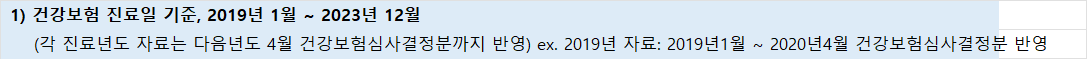

---
- 2024년 1월 2일부로, 부천시의 구와 행정동이 부활함 (소사구/오정구/원미구)
- 데이터 수집기준에 따르면, 행정구역 변화 이후(24년 1월 이후)부터 각 구별 데이터를 따로 수집하기 시작했을 것으로 추측
- 따라서, 3개 구의 내용을 합해야 할 것으로 보임

**2. 군위군**

In [38]:
# 군위군
patients[patients["시군구"]=="군위군"]

,시도,시군구,불안장애,조울증,우울증,불면증
206,경북,군위군,72,0,24,164


- 정신질환 데이터에는 `경북 군위군`이 존재 (다른 데이터에는 `대구 군위군`만 존재)
- 2023년 7월 1일부로, `군위군`은 경북에서 대구로 편입되었음
    - 경북 군위군 데이터가 2023년 6월까지의 누적 내용일 것으로 판단하여, **경북 군위군을 제거**하고 사용

---

**지역명 수정**

1. 시와 구가 같이 있음 → 시 단위로 통합
    - 경기도: 부천
    ---
2. 구가 있음 → 시 단위로 통합
    - 경기도: 성남, 수원, 안양, 안산, 고양, 용인
    - 경상남도: 창원
    - 경상북도: 포항
    - 전라북도: 전주
    - 충청남도: 천안
    - 충청북도: 청주
    ---
3. 광역시명이 앞에 붙어있음 → 광역시명 제거
    - 광주, 대구, 대전, 부산, 울산, 인천
    - **`부산진구`는 '부산' 제거하면 안됨!!**

In [39]:
# 통합 대상인 시군구명 수정

# 1. 시와 구가 같이 있는 경우 : "-시"로 통합
# 부천시
patients.loc[
    (patients["시군구"].str.startswith("부천")) & 
    (patients["시군구"].str.endswith("구")), "시군구"] = "부천시"


# 2. 구만 있는 경우 : "-시"로 통합
no_si_list = {"경기": ["성남", "수원", "안양", "안산", "고양", "용인"],
             "경남": ["창원"],
             "경북": ["포항"],
             "전북": ["전주"],
             "충남": ["천안"],
             "충북": ["청주"]}

# 각 시도별 시군구명 수정
for sido in no_si_list.keys():
    for sigungu in no_si_list[sido]:
        patients.loc[(patients["시도"]==sido) & (patients["시군구"].str.startswith(sigungu)), "시군구"] = (sigungu+"시")

        
# 3. 광역시명 붙은 경우 : 시군구명에서 광역시명 제거
remove_sido_list = ["광주", "대구", "대전", "부산", "울산", "인천"]

# 시군구명에서 시도명 제거
cond = patients["시도"].isin(remove_sido_list)
patients.loc[cond, "시군구"] = patients.loc[cond, "시군구"].str[2:]

# '부산진구'  변경
patients.loc[patients["시군구"]=="진구", "시군구"] = "부산진구"

# '경북 군위군' 제거
cond = (patients["시도"]=="경북") & (patients["시군구"]=="군위군")
patients.drop(index=patients[cond].index, axis=0, inplace=True)


# 4. 다시 groupby 수행
patients = patients.groupby(["시도","시군구"]).sum().reset_index()

# 확인
patients

,시도,시군구,불안장애,조울증,우울증,불면증
0,강원,강릉시,5596,543,5637,3483
1,강원,고성군,601,0,88,239
2,강원,동해시,1705,277,1163,1310
3,강원,삼척시,1149,88,1413,838
4,강원,속초시,1584,78,1572,1230
...,...,...,...,...,...,...
224,충북,제천시,1493,184,3826,1998
225,충북,증평군,233,0,621,565
226,충북,진천군,1413,127,1678,911
227,충북,청주시,16547,2125,21181,13415


# 3. 정신질환 심각도 산출

- **질환별 정신질환 심각도**를 각 질환별 **인구수 대비 환자수의 Z-score**로 정의
- **정신질환 심각도**는 각 질환별 **점수의 합**으로 정의

## 3-1. 시도별

In [40]:
# 시도명 리스트 생성 (도서관 데이터 기준)
sido_list = sorted(users["시도"].unique())
sido_list

['강원',
 '경기',
 '경남',
 '경북',
 '광주',
 '대구',
 '대전',
 '부산',
 '서울',
 '세종',
 '울산',
 '인천',
 '전남',
 '전북',
 '제주',
 '충남',
 '충북']

In [41]:
# 시도별 정신질환자수 데이터
sido_patients = patients.groupby("시도").sum()

# 인구수 컬럼 추가
sido_patients = pd.merge(sido_patients, sido_population, on=["시도"])

# 인구대비 비율
sido_patients["불안장애비율"] = (sido_patients["불안장애"] / sido_patients["인구수"] * 100).round(2)
sido_patients["조울증비율"] = (sido_patients["조울증"] / sido_patients["인구수"] * 100).round(2)
sido_patients["우울증비율"] = (sido_patients["우울증"] / sido_patients["인구수"] * 100).round(2)
sido_patients["불면증비율"] = (sido_patients["불면증"] / sido_patients["인구수"] * 100).round(2)

# 확인
sido_patients

C:\Users\louis\AppData\Local\Temp\ipykernel_27420\416069395.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sido_patients = patients.groupby("시도").sum()


,시도,불안장애,조울증,우울증,불면증,인구수,불안장애비율,조울증비율,우울증비율,불면증비율
0,강원,28485,3413,27395,20608,1527807,1.86,0.22,1.79,1.35
1,경기,222482,38986,275651,195686,13630821,1.63,0.29,2.02,1.44
2,경남,52869,7338,48927,48631,3251158,1.63,0.23,1.50,1.50
3,경북,37121,5330,41219,36296,2554324,1.45,0.21,1.61,1.42
4,광주,22781,3156,29861,17657,1419237,1.61,0.22,2.10,1.24
5,대구,55678,6445,52207,44101,2374960,2.34,0.27,2.20,1.86
6,대전,36979,4292,33022,23181,1442216,2.56,0.30,2.29,1.61
7,부산,72410,8751,84531,62160,3293362,2.20,0.27,2.57,1.89
8,서울,197424,45983,286997,169692,9386034,2.10,0.49,3.06,1.81
9,세종,4969,686,10322,2910,386525,1.29,0.18,2.67,0.75


**Z-score 산출**

In [42]:


# 질환별 Z-score 산출
x = sido_patients[["불안장애비율","조울증비율","우울증비율","불면증비율"]]
sido_zscore = ss.zscore(x)

# 컬럼명 수정
sido_zscore.columns = sido_zscore.columns.str.replace("비율","점수")

# 각 장애별 점수 합산
sido_zscore["총점수"] = sido_zscore.sum(axis=1)

# 시도 컬럼 추가
sido_zscore.insert(0, "시도", sido_patients["시도"])

# 확인
sido_zscore

,시도,불안장애점수,조울증점수,우울증점수,불면증점수,총점수
0,강원,0.266009,-0.376012,-0.559729,-0.266366,-0.936099
1,경기,-0.413791,0.576018,-0.041118,0.064967,0.186077
2,경남,-0.413791,-0.240008,-1.213630,0.285856,-1.581573
3,경북,-0.945808,-0.512016,-0.965599,-0.008662,-2.432086
4,광주,-0.472904,-0.376012,0.139269,-0.671329,-1.380976
5,대구,1.684721,0.304010,0.364752,1.611190,3.964673
6,대전,2.334964,0.712023,0.567687,0.690819,4.305493
7,부산,1.270930,0.304010,1.199040,1.721634,4.495614
8,서울,0.975365,3.296105,2.303908,1.427116,8.002494
9,세종,-1.418712,-0.920029,1.424523,-2.475256,-3.389474


## 3-2. 시군구별

In [43]:
# 시군구별 정신질환자수 및 인구수 데이터
sigungu_patients = pd.merge(patients, sigungu_population, on=["시도","시군구"])

# 인구대비 비율
sigungu_patients["불안장애비율"] = (sigungu_patients["불안장애"] / sigungu_patients["인구수"] * 100).round(2)
sigungu_patients["조울증비율"] = (sigungu_patients["조울증"] / sigungu_patients["인구수"] * 100).round(2)
sigungu_patients["우울증비율"] = (sigungu_patients["우울증"] / sigungu_patients["인구수"] * 100).round(2)
sigungu_patients["불면증비율"] = (sigungu_patients["불면증"] / sigungu_patients["인구수"] * 100).round(2)

# 확인
sigungu_patients

,시도,시군구,불안장애,조울증,우울증,불면증,인구수,불안장애비율,조울증비율,우울증비율,불면증비율
0,강원,강릉시,5596,543,5637,3483,209439,2.67,0.26,2.69,1.66
1,강원,고성군,601,0,88,239,27305,2.20,0.00,0.32,0.88
2,강원,동해시,1705,277,1163,1310,88625,1.92,0.31,1.31,1.48
3,강원,삼척시,1149,88,1413,838,62651,1.83,0.14,2.26,1.34
4,강원,속초시,1584,78,1572,1230,82054,1.93,0.10,1.92,1.50
...,...,...,...,...,...,...,...,...,...,...,...
224,충북,제천시,1493,184,3826,1998,130194,1.15,0.14,2.94,1.53
225,충북,증평군,233,0,621,565,37484,0.62,0.00,1.66,1.51
226,충북,진천군,1413,127,1678,911,86254,1.64,0.15,1.95,1.06
227,충북,청주시,16547,2125,21181,13415,852189,1.94,0.25,2.49,1.57


**Z-Score 산출**

In [44]:
# 질환별 Z-score 산출
x = sigungu_patients[["불안장애비율","조울증비율","우울증비율","불면증비율"]]
sigungu_zscore = ss.zscore(x)

# 컬럼명 수정
sigungu_zscore.columns = sigungu_zscore.columns.str.replace("비율","점수")

# 각 장애별 점수 합산
sigungu_zscore["총점수"] = sigungu_zscore.sum(axis=1)

# 시도, 시군구 컬럼 추가
sigungu_zscore.insert(0, "시도", sigungu_patients["시도"])
sigungu_zscore.insert(1, "시군구", sigungu_patients["시군구"])

# 확인
sigungu_zscore

,시도,시군구,불안장애점수,조울증점수,우울증점수,불면증점수,총점수
0,강원,강릉시,1.218230,0.116555,0.743705,0.348757,2.427248
1,강원,고성군,0.688203,-0.930156,-1.143304,-1.134457,-2.519713
2,강원,동해시,0.372442,0.317846,-0.355059,0.006477,0.341706
3,강원,삼척시,0.270948,-0.366542,0.401337,-0.259741,0.046001
4,강원,속초시,0.383719,-0.527575,0.130627,0.044508,0.031279
...,...,...,...,...,...,...,...
224,충북,제천시,-0.495900,-0.366542,0.942757,0.101555,0.181869
225,충북,증평군,-1.093590,-0.930156,-0.076387,0.063524,-2.036610
226,충북,진천군,0.056681,-0.326284,0.154513,-0.792177,-0.907267
227,충북,청주시,0.394996,0.076297,0.584464,0.177617,1.233375


## 3-3. 점수 분포 시각화

**시도별**

In [45]:
sido_zscore.head()

,시도,불안장애점수,조울증점수,우울증점수,불면증점수,총점수
0,강원,0.266009,-0.376012,-0.559729,-0.266366,-0.936099
1,경기,-0.413791,0.576018,-0.041118,0.064967,0.186077
2,경남,-0.413791,-0.240008,-1.213630,0.285856,-1.581573
3,경북,-0.945808,-0.512016,-0.965599,-0.008662,-2.432086
4,광주,-0.472904,-0.376012,0.139269,-0.671329,-1.380976


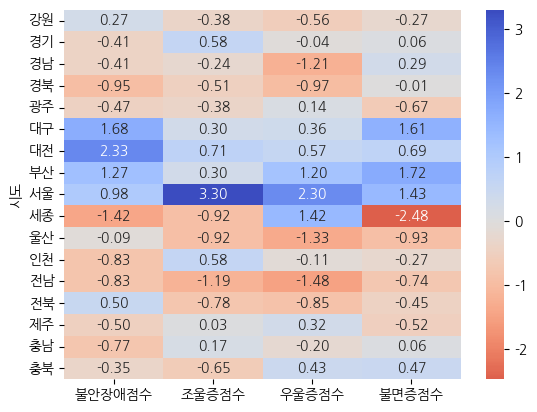

In [46]:
# 시도별 정신질환 점수
h = sns.heatmap(sido_zscore.set_index("시도").drop(columns="총점수"), 
                annot=True, fmt=".2f", cmap="coolwarm_r", center=0)

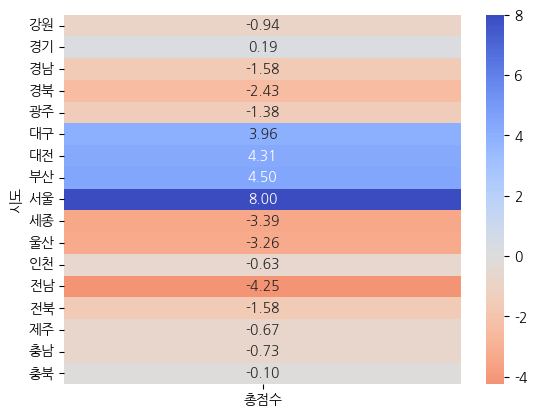

In [47]:
# 시도별 총 점수
h = sns.heatmap(sido_zscore.set_index("시도")[["총점수"]], 
                annot=True, fmt=".2f", cmap="coolwarm_r", center=0)

- 서울의 조울증, 우울증 점수가 높음
- 대전의 불안장애 점수가 높음
- 세종의 불면증 점수가 낮음
    - 세종의 규모가 작아서, 불면증 환자 수가 적기 때문에 점수가 낮을 듯 하다.
---

**시군구별**

In [48]:
sigungu_zscore.head()

,시도,시군구,불안장애점수,조울증점수,우울증점수,불면증점수,총점수
0,강원,강릉시,1.218230,0.116555,0.743705,0.348757,2.427248
1,강원,고성군,0.688203,-0.930156,-1.143304,-1.134457,-2.519713
2,강원,동해시,0.372442,0.317846,-0.355059,0.006477,0.341706
3,강원,삼척시,0.270948,-0.366542,0.401337,-0.259741,0.046001
4,강원,속초시,0.383719,-0.527575,0.130627,0.044508,0.031279


불안장애점수


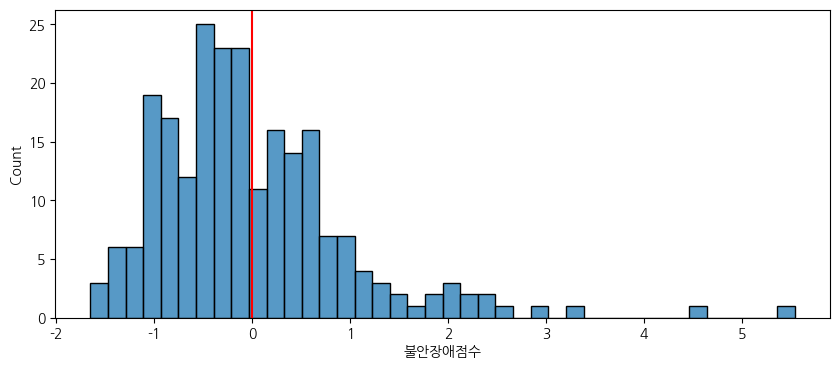

조울증점수


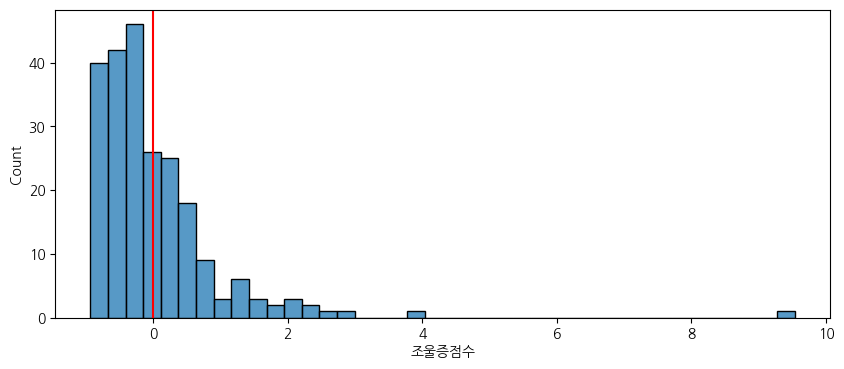

우울증점수


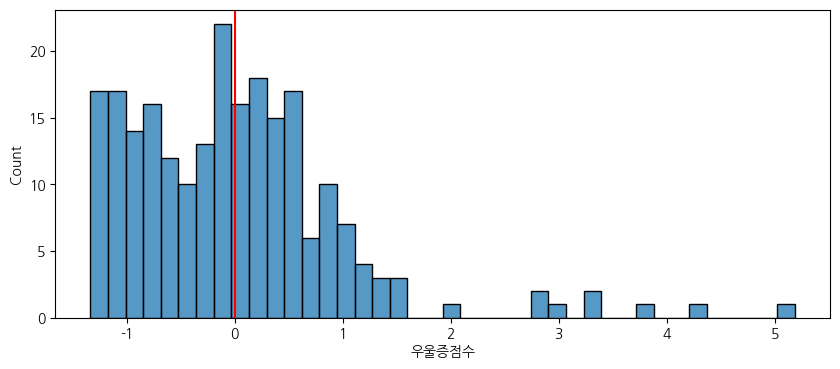

불면증점수


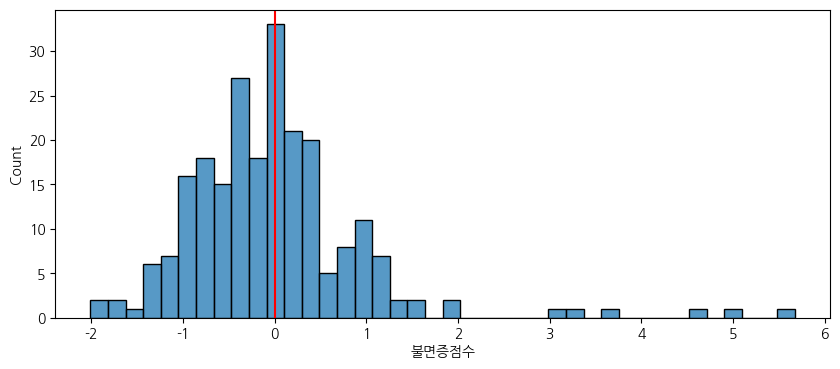

총점수


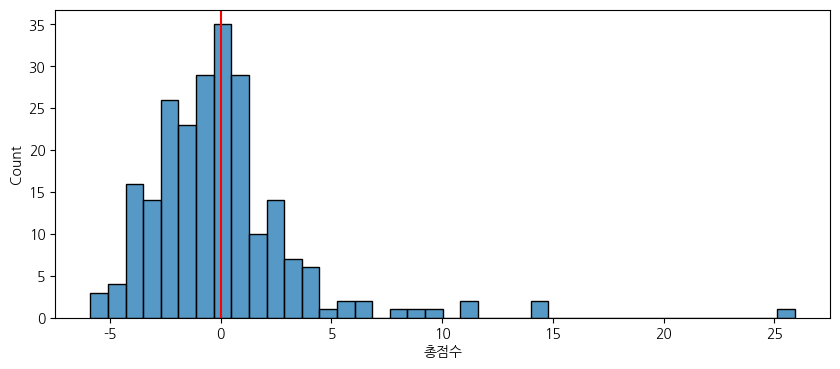

In [49]:
# 각 정신질환별 점수 분포 확인
for col in sigungu_zscore.columns.to_list()[2:]:
    print(col)
    plt.figure(figsize=(10,4))
    sns.histplot(data=sigungu_zscore, x=col, bins=40)
    plt.axvline(x=0, color="r")
    plt.show()

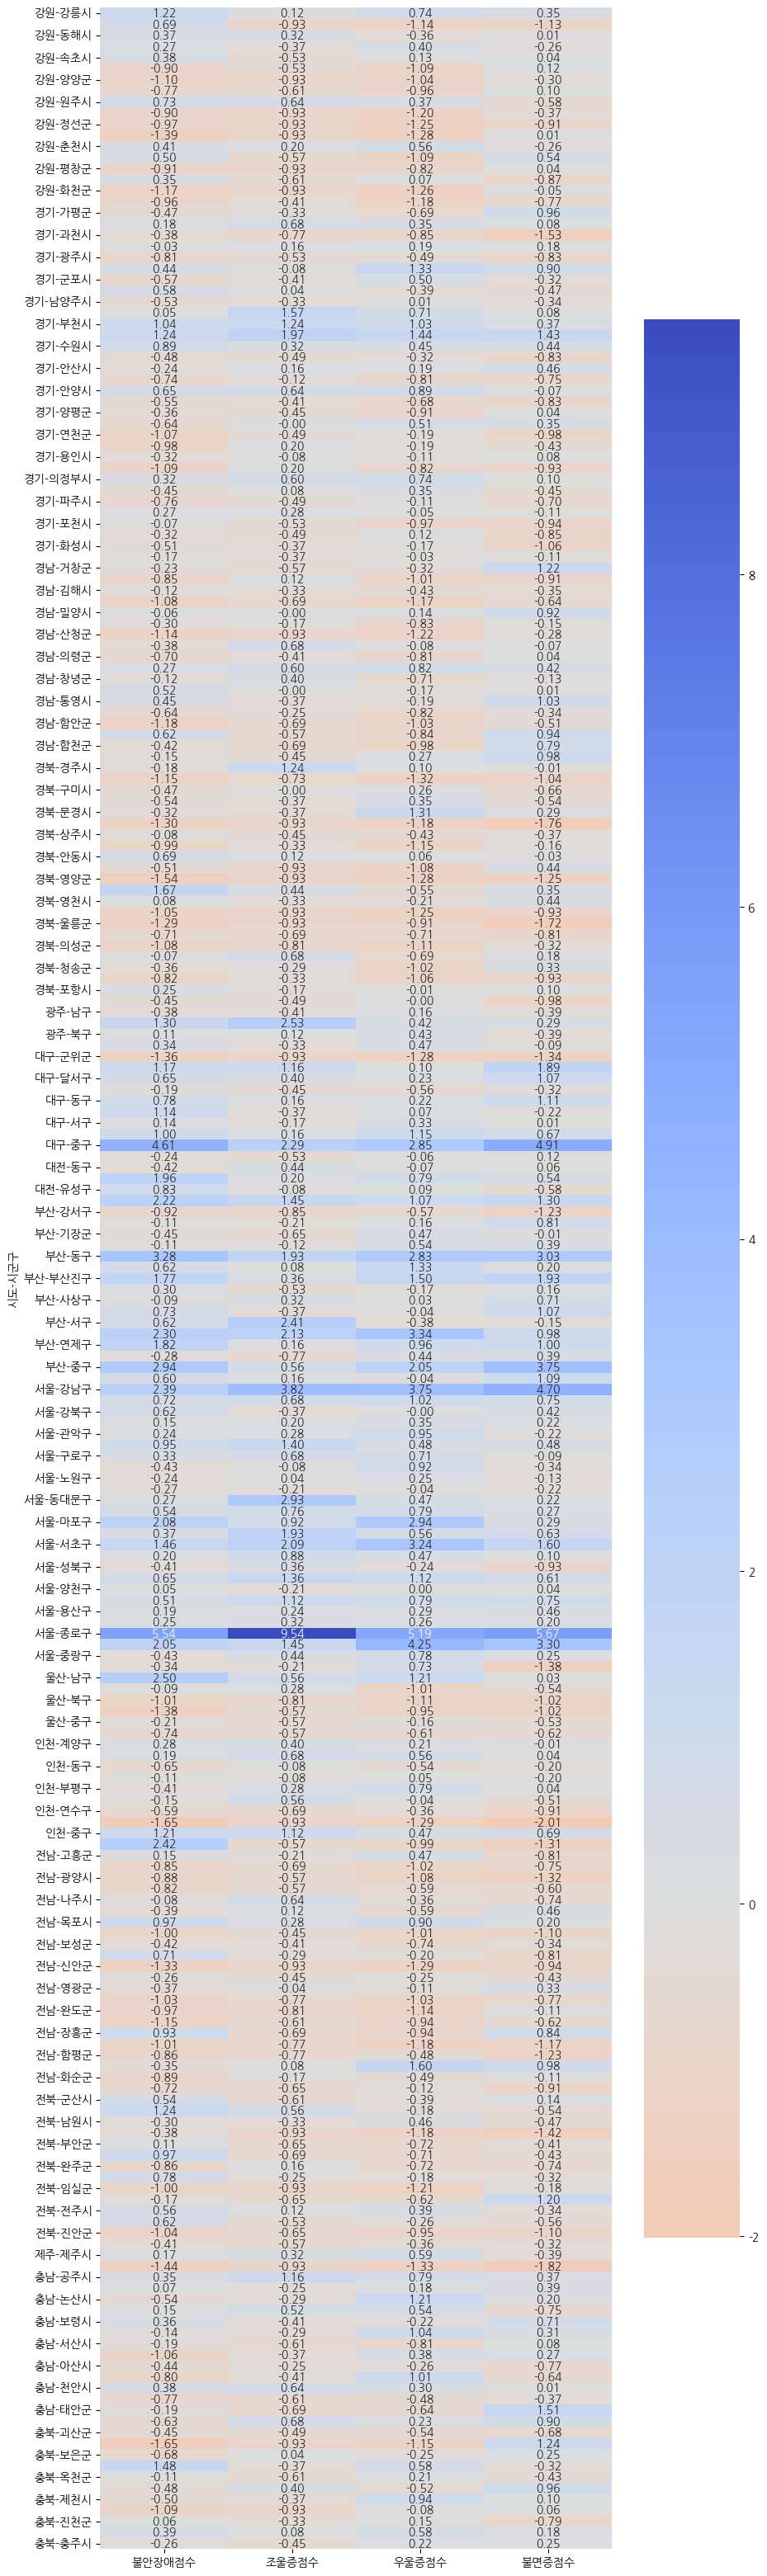

In [50]:
# 시군구별 정신질환 점수
plt.figure(figsize=(10,40))
h = sns.heatmap(sigungu_zscore.set_index(["시도","시군구"]).drop(columns="총점수"), 
                annot=True, fmt=".2f", cmap="coolwarm_r", center=0)

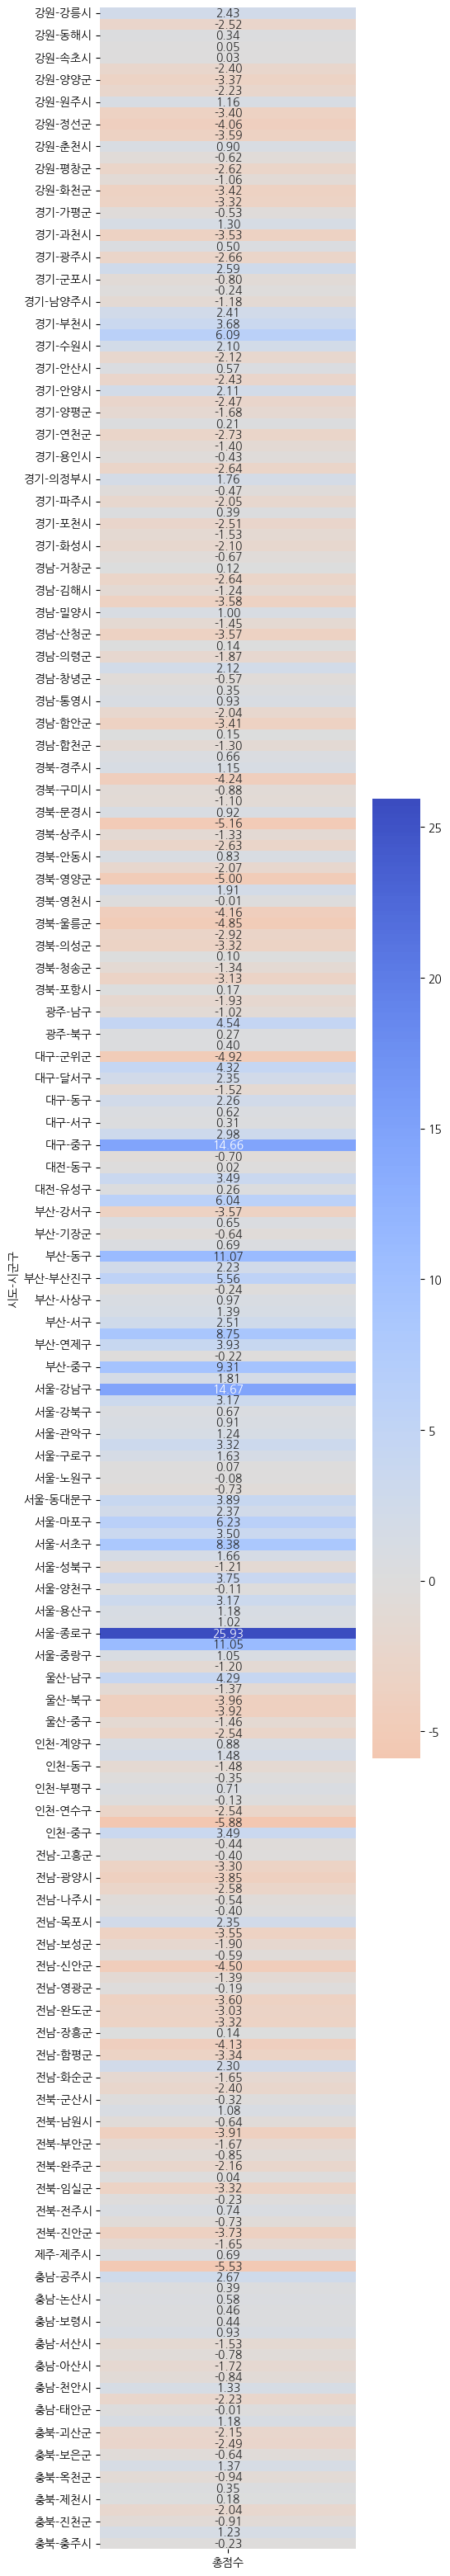

In [51]:
# 시군구별 총 점수
plt.figure(figsize=(5,40))
h = sns.heatmap(sigungu_zscore.set_index(["시도","시군구"])[["총점수"]], 
                annot=True, fmt=".2f", cmap="coolwarm_r", center=0)

- 종로구
    - 다른 지역에 비해 조울증 환자 수가 많은 듯 하다.
    - 조울증 뿐만 아니라, 전체적으로 모든 질환의 환자수가 많은 편이다.
    - 종로구에 정신병원이 많은 듯하다.

# 4. 도서관 요인과 정신질환 심각도의 관계

## 4-1. 이용률과의 상관분석 : 시도 단위

**도서관 이용률**
- **인구수 대비 도서관 이용자수**를 도서관 이용률로 정의

In [52]:
# 도서관 이용률 데이터 생성

# 시도별 이용자수 집계
sido_users = users.groupby("시도")["이용자수"].sum().to_frame()
sido_users.reset_index(inplace=True)

# 인구-이용자수 병합
sido_use_rate = pd.merge(sido_users, sido_population)

# 이용률 컬럼 생성
sido_use_rate["이용률"] = (sido_use_rate["이용자수"] / sido_use_rate["인구수"]).round(2)

# 확인
sido_use_rate

,시도,이용자수,인구수,이용률
0,강원,5704476,1527807,3.73
1,경기,60832087,13630821,4.46
2,경남,12553127,3251158,3.86
3,경북,8051419,2554324,3.15
4,광주,5616758,1419237,3.96
5,대구,7913886,2374960,3.33
6,대전,4896414,1442216,3.40
7,부산,10008716,3293362,3.04
8,서울,47538209,9386034,5.06
9,세종,1363999,386525,3.53


<AxesSubplot: >

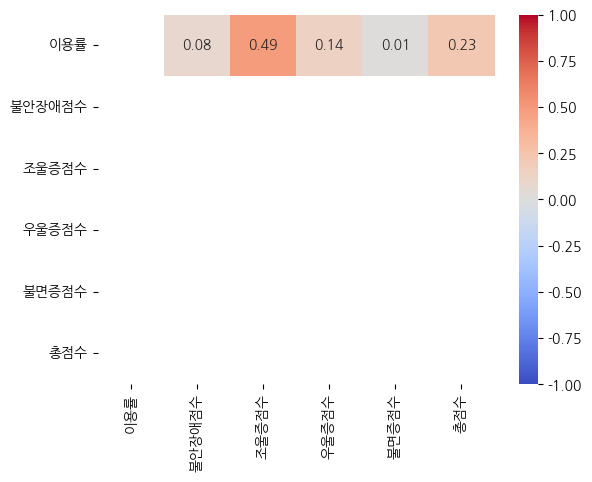

In [53]:
# 상관분석

# 병합 데이터 생성
sido_df = pd.merge(sido_use_rate[["시도","이용률"]], sido_zscore, on="시도")

# 상관계수 산출
sido_corr = sido_df.drop(columns="시도").corr()

# mask 세팅
mask = np.array([[True]+[False]*5] + [[True]*6]*5)

# 시각화
sns.heatmap(sido_corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmin=-1, vmax=1)

- 총점수와의 상관계수는 0.23
    - 의미가 있다고 보기에는 낮은 수치인 듯하다.
- 조울증과의 상관계수가 0.49로 상당히 높다.

## 4-2. 이용률과의 상관분석 : 시군구 단위

In [54]:
# 도서관 이용률 데이터 생성

# 인구-이용자수 병합
sigungu_use_rate = pd.merge(users, sigungu_population, on=["시도","시군구"])

# 이용률 컬럼 생성
sigungu_use_rate["이용률"] = (sigungu_use_rate["이용자수"] / sigungu_use_rate["인구수"]).round(2)

# 확인
sigungu_use_rate

,시도,시군구,이용자수,인구수,이용률
0,강원,강릉시,654584,209439,3.13
1,강원,고성군,60968,27305,2.23
2,강원,동해시,460423,88625,5.20
3,강원,삼척시,259590,62651,4.14
4,강원,속초시,433719,82054,5.29
...,...,...,...,...,...
224,충북,제천시,290175,130194,2.23
225,충북,증평군,267482,37484,7.14
226,충북,진천군,348227,86254,4.04
227,충북,청주시,1327224,852189,1.56


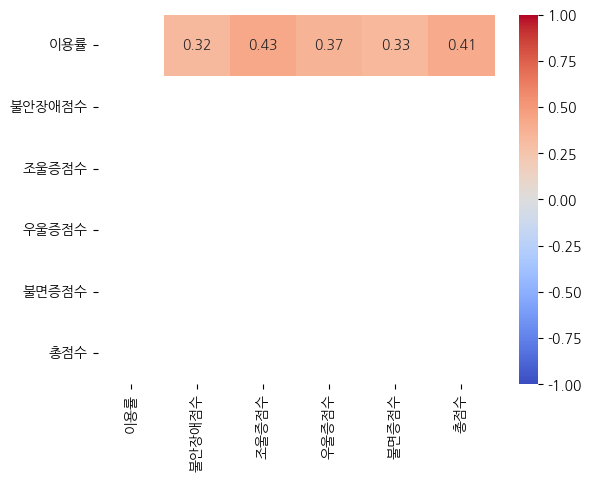

In [55]:
# 상관분석

# 병합 데이터 생성
sigungu_df = pd.merge(sigungu_use_rate[["시도","시군구","이용률"]], sigungu_zscore, on=["시도","시군구"])

# 상관계수 산출
sigungu_corr = sigungu_df.drop(columns=["시도","시군구"]).corr()

# mask 세팅
mask = np.array([[True]+[False]*5] + [[True]*6]*5)

# 시각화
sns.heatmap(sigungu_corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmin=-1, vmax=1)

plt.show()

- 시군구 단위로 세분화하니까 상관계수가 확실히 높아졌다.
- 총점수와의 상관계수는 0.41 (시도는 0.23)
- 조울증과의 상관계수는 0.43 (시도는 0.49)로, 질환 중 가장 높다.
---

## 4-3. 회귀분석 : 유의미한 변수 선택

- 도서관의 요인 중 정신질환 심각도와 유의미한 관계를 갖는 변수를 확인
- 회귀분석을 진행하여, 유의수준(alpha=0.05)을 만족하는 변수를 선택

In [56]:
# 후보 변수 선정
columns = [
    '도서관총예산',
    '국내서_합계',
    '국외서_합계',
    '면적_도서관서비스제공면적',
    '좌석수_총좌석수_총좌석수',
    '설비_이용자용컴퓨터수',
    '일수및시간_연간총개관일수',
    '일수및시간_주당평균개관시간',
    '이용자수_도서관방문자수',
    '홈페이지접속 수',
    '모바일웹접속건 수'
]

In [57]:
# 데이터셋 생성
small_library = pd.concat([library[columns].astype('int64'), library[['지역', '시군구']]], axis=1)\
    .groupby(['지역', '시군구'], as_index=False).mean().rename(columns={'지역': '시도'})
small_library

,시도,시군구,도서관총예산,국내서_합계,국외서_합계,면적_도서관서비스제공면적,좌석수_총좌석수_총좌석수,설비_이용자용컴퓨터수,일수및시간_연간총개관일수,일수및시간_주당평균개관시간,이용자수_도서관방문자수,홈페이지접속 수,모바일웹접속건 수
0,강원,강릉시,1.707489e+06,117380.500000,2091.000000,1907.250000,336.500000,35.500000,287.000000,82.500000,163646.000000,260409.500000,15275.750000
1,강원,고성군,4.001840e+05,47839.666667,0.000000,559.333333,128.666667,10.000000,275.333333,46.666667,20322.666667,238579.333333,126758.666667
2,강원,동해시,2.170466e+06,94575.250000,466.750000,1580.250000,264.000000,18.000000,235.500000,74.000000,115105.750000,415385.500000,130896.000000
3,강원,삼척시,7.996870e+05,113185.000000,1529.666667,1682.000000,122.333333,21.666667,282.333333,48.000000,86530.000000,33638.333333,32694.000000
4,강원,속초시,1.267451e+06,92662.000000,1082.000000,1514.000000,199.333333,28.666667,297.666667,57.333333,144573.000000,67647.333333,95113.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,충북,제천시,2.119106e+06,104792.666667,1440.833333,1130.166667,132.000000,13.666667,249.666667,51.000000,48362.500000,143664.333333,10353.000000
225,충북,증평군,4.474160e+05,58720.500000,3722.000000,1522.500000,268.000000,12.000000,300.000000,68.000000,133741.000000,9500.000000,10410.000000
226,충북,진천군,6.860290e+05,68457.250000,3822.000000,1794.750000,202.500000,19.750000,294.250000,50.250000,87056.750000,244166.250000,316278.000000
227,충북,청주시,1.573477e+06,106026.736842,3870.789474,1560.842105,163.526316,14.315789,292.736842,62.421053,69853.894737,153199.000000,38474.421053


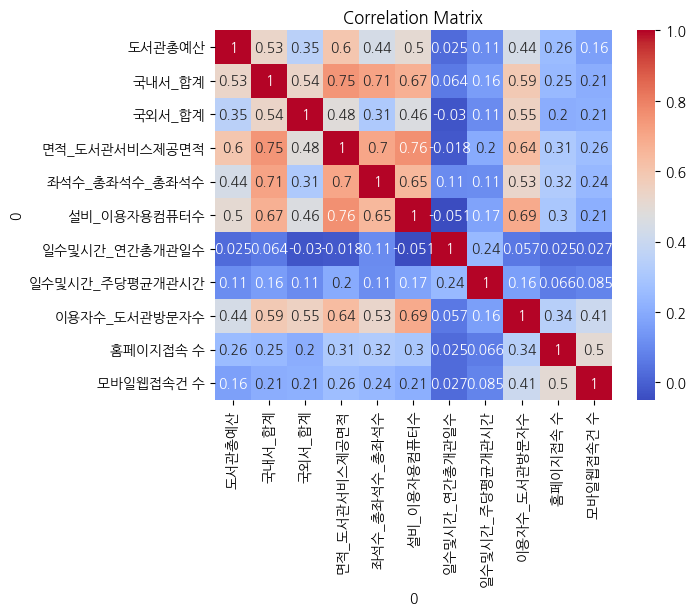

In [58]:
# 변수 간 상관관계 확인
sns.heatmap(small_library.drop(columns=["시도","시군구"]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [59]:
# 정신질환 점수 추가
big_df = pd.merge(
    small_library,
    sigungu_zscore,
    how='left',
    on=['시도', '시군구']
).drop(['불안장애점수', '조울증점수', '우울증점수', '불면증점수'], axis=1)

big_df

,시도,시군구,도서관총예산,국내서_합계,국외서_합계,면적_도서관서비스제공면적,좌석수_총좌석수_총좌석수,설비_이용자용컴퓨터수,일수및시간_연간총개관일수,일수및시간_주당평균개관시간,이용자수_도서관방문자수,홈페이지접속 수,모바일웹접속건 수,총점수
0,강원,강릉시,1.707489e+06,117380.500000,2091.000000,1907.250000,336.500000,35.500000,287.000000,82.500000,163646.000000,260409.500000,15275.750000,2.427248
1,강원,고성군,4.001840e+05,47839.666667,0.000000,559.333333,128.666667,10.000000,275.333333,46.666667,20322.666667,238579.333333,126758.666667,-2.519713
2,강원,동해시,2.170466e+06,94575.250000,466.750000,1580.250000,264.000000,18.000000,235.500000,74.000000,115105.750000,415385.500000,130896.000000,0.341706
3,강원,삼척시,7.996870e+05,113185.000000,1529.666667,1682.000000,122.333333,21.666667,282.333333,48.000000,86530.000000,33638.333333,32694.000000,0.046001
4,강원,속초시,1.267451e+06,92662.000000,1082.000000,1514.000000,199.333333,28.666667,297.666667,57.333333,144573.000000,67647.333333,95113.000000,0.031279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,충북,제천시,2.119106e+06,104792.666667,1440.833333,1130.166667,132.000000,13.666667,249.666667,51.000000,48362.500000,143664.333333,10353.000000,0.181869
225,충북,증평군,4.474160e+05,58720.500000,3722.000000,1522.500000,268.000000,12.000000,300.000000,68.000000,133741.000000,9500.000000,10410.000000,-2.036610
226,충북,진천군,6.860290e+05,68457.250000,3822.000000,1794.750000,202.500000,19.750000,294.250000,50.250000,87056.750000,244166.250000,316278.000000,-0.907267
227,충북,청주시,1.573477e+06,106026.736842,3870.789474,1560.842105,163.526316,14.315789,292.736842,62.421053,69853.894737,153199.000000,38474.421053,1.233375


In [60]:
# 회귀분석에 사용할 데이터 세팅
X = big_df[[
    '도서관총예산', '국내서_합계', '국외서_합계', '면적_도서관서비스제공면적', '좌석수_총좌석수_총좌석수',
       '설비_이용자용컴퓨터수', '일수및시간_연간총개관일수', '일수및시간_주당평균개관시간', '이용자수_도서관방문자수',
       '홈페이지접속 수', '모바일웹접속건 수']]
y = big_df['총점수']

In [61]:
# 회귀분석 수행
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# 결과 출력
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    총점수   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     7.876
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           1.80e-11
Time:                        21:34:33   Log-Likelihood:                -574.00
No. Observations:                 229   AIC:                             1172.
Df Residuals:                     217   BIC:                             1213.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7453      2.193     -0.340      0.734      -5.067       3.577
도서관총예산         -1.842e-08   2.55e-07     -0.072      0.942   -5.21e-07    4.84e-07
국내서_합계          2.758e-05   8.26e-06      3.339      0.001    1.13e-05    4.39e-05
국외서_합계           3.82e-05   5.48e-05      0.697      0.486   -6.98e-05       0.000
면적_도서관서비스제공면적      0.0001      0.001      0.186      0.852      -0.001       0.001
좌석수_총좌석수_총좌석수     -0.0057      0.002     -2.583      0.010      -0.010      -0.001
설비_이용자용컴퓨터수       -0.0363      0.035     -1.027      0.305      -0.106       0.033
일수및시간_연간총개관일수     -0.0003      0.007     -0.044      0.965      -0.015       0.014
일수및시간_주당평균개관시간    -0.0303      0.021     -1.428      0.155      -0.072       0.012
이용자수_도서관방문자수    1.159e-05   3.38e-06      3.433      0.001    4.93e-06    1.82e-05
홈페이지접속 수        6.765e-07   5.13e-07      1.320      0.188   -3.34e-07    1.69e-06
모바일웹접속건 수       1.635e-06   7.65e-07      2.138      0.034    1.28e-07    3.14e-06
==============================================================================
Omnibus:                      177.228   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3477.627
Skew:                           2.773   Prob(JB):                         0.00
Kurtosis:                      21.268   Cond. No.                     1.73e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
# p-value가 0.05보다 작은 변수 확인
selected_x = model.pvalues[model.pvalues<0.05].index
model.pvalues[selected_x]

국내서_합계           0.000991
좌석수_총좌석수_총좌석수    0.010449
이용자수_도서관방문자수     0.000716
모바일웹접속건 수        0.033613
dtype: float64

In [63]:
# 해당 변수들의 회귀계수 확인
model.params[selected_x]

국내서_합계           0.000028
좌석수_총좌석수_총좌석수   -0.005686
이용자수_도서관방문자수     0.000012
모바일웹접속건 수        0.000002
dtype: float64

# 5. 군집분석

- 위에서 도출한 변수들을 사용하여, 유사한 특성을 갖는 지역별로 클러스터링을 수행

In [64]:
# 도서관 이용률 추가
big_big_df = pd.concat([big_df, sigungu_use_rate], axis=1)

# 컬럼 수정
big_big_df['소장도서수'] = big_big_df['국내서_합계'] + big_big_df['국외서_합계']
big_big_df['좌석수'] = big_big_df['좌석수_총좌석수_총좌석수']

# 확인
big_big_df

,시도,시군구,도서관총예산,국내서_합계,국외서_합계,면적_도서관서비스제공면적,좌석수_총좌석수_총좌석수,설비_이용자용컴퓨터수,일수및시간_연간총개관일수,일수및시간_주당평균개관시간,...,홈페이지접속 수,모바일웹접속건 수,총점수,시도,시군구,이용자수,인구수,이용률,소장도서수,좌석수
0,강원,강릉시,1.707489e+06,117380.500000,2091.000000,1907.250000,336.500000,35.500000,287.000000,82.500000,...,260409.500000,15275.750000,2.427248,강원,강릉시,654584,209439,3.13,119471.500000,336.500000
1,강원,고성군,4.001840e+05,47839.666667,0.000000,559.333333,128.666667,10.000000,275.333333,46.666667,...,238579.333333,126758.666667,-2.519713,강원,고성군,60968,27305,2.23,47839.666667,128.666667
2,강원,동해시,2.170466e+06,94575.250000,466.750000,1580.250000,264.000000,18.000000,235.500000,74.000000,...,415385.500000,130896.000000,0.341706,강원,동해시,460423,88625,5.20,95042.000000,264.000000
3,강원,삼척시,7.996870e+05,113185.000000,1529.666667,1682.000000,122.333333,21.666667,282.333333,48.000000,...,33638.333333,32694.000000,0.046001,강원,삼척시,259590,62651,4.14,114714.666667,122.333333
4,강원,속초시,1.267451e+06,92662.000000,1082.000000,1514.000000,199.333333,28.666667,297.666667,57.333333,...,67647.333333,95113.000000,0.031279,강원,속초시,433719,82054,5.29,93744.000000,199.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,충북,제천시,2.119106e+06,104792.666667,1440.833333,1130.166667,132.000000,13.666667,249.666667,51.000000,...,143664.333333,10353.000000,0.181869,충북,제천시,290175,130194,2.23,106233.500000,132.000000
225,충북,증평군,4.474160e+05,58720.500000,3722.000000,1522.500000,268.000000,12.000000,300.000000,68.000000,...,9500.000000,10410.000000,-2.036610,충북,증평군,267482,37484,7.14,62442.500000,268.000000
226,충북,진천군,6.860290e+05,68457.250000,3822.000000,1794.750000,202.500000,19.750000,294.250000,50.250000,...,244166.250000,316278.000000,-0.907267,충북,진천군,348227,86254,4.04,72279.250000,202.500000
227,충북,청주시,1.573477e+06,106026.736842,3870.789474,1560.842105,163.526316,14.315789,292.736842,62.421053,...,153199.000000,38474.421053,1.233375,충북,청주시,1327224,852189,1.56,109897.526316,163.526316


In [65]:
# 사용할 컬럼만 추출
small_small_df = big_big_df[['소장도서수', '좌석수', '모바일웹접속건 수', '이용률', '총점수']].rename(columns={'모바일웹접속건 수': '모바일웹접속건수'})
small_small_df

,소장도서수,좌석수,모바일웹접속건수,이용률,총점수
0,119471.500000,336.500000,15275.750000,3.13,2.427248
1,47839.666667,128.666667,126758.666667,2.23,-2.519713
2,95042.000000,264.000000,130896.000000,5.20,0.341706
3,114714.666667,122.333333,32694.000000,4.14,0.046001
4,93744.000000,199.333333,95113.000000,5.29,0.031279
...,...,...,...,...,...
224,106233.500000,132.000000,10353.000000,2.23,0.181869
225,62442.500000,268.000000,10410.000000,7.14,-2.036610
226,72279.250000,202.500000,316278.000000,4.04,-0.907267
227,109897.526316,163.526316,38474.421053,1.56,1.233375


In [66]:
# 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(small_small_df.drop('총점수', axis=1))
X

array([[ 4.96485870e-01,  3.93884841e-01, -5.29073156e-01,
        -2.51839081e-01],
       [-1.05330932e+00, -9.98043221e-01, -1.85182280e-01,
        -6.67570235e-01],
       [-3.20601672e-02, -9.16714600e-02, -1.72419865e-01,
         7.04342573e-01],
       [ 3.93569093e-01, -1.04045963e+00, -4.75343155e-01,
         2.14703658e-01],
       [-6.01431307e-02, -5.24765356e-01, -2.82799533e-01,
         7.45915688e-01],
       [-3.49497178e-01,  2.14523619e+00, -3.85485968e-01,
         2.70134479e-01],
       [-5.53022939e-01, -5.93971081e-01, -4.35454954e-01,
        -1.36358205e-01],
       [-6.14522033e-01, -1.00585677e+00, -5.56043422e-01,
        -9.90916688e-01],
       [ 9.20236442e-01,  1.58377683e+00, -9.75275663e-02,
        -2.51839081e-01],
       [-1.20465010e+00, -8.81956198e-01, -5.45842847e-01,
         1.91607483e-01],
       [-7.75544726e-01, -8.68561541e-01, -5.48405715e-01,
        -4.50466188e-01],
       [-8.79671292e-01, -4.91836825e-01, -5.15323125e-01,
      

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3

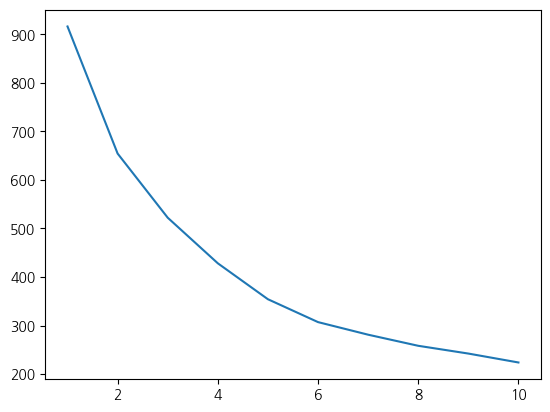

In [67]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.show()

In [68]:
kmeans = KMeans(n_clusters=4, random_state=42)
small_small_df['클러스터'] = kmeans.fit_predict(X)
small_small_df

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,소장도서수,좌석수,모바일웹접속건수,이용률,총점수,클러스터
0,119471.500000,336.500000,15275.750000,3.13,2.427248,0
1,47839.666667,128.666667,126758.666667,2.23,-2.519713,3
2,95042.000000,264.000000,130896.000000,5.20,0.341706,0
3,114714.666667,122.333333,32694.000000,4.14,0.046001,3
4,93744.000000,199.333333,95113.000000,5.29,0.031279,0
...,...,...,...,...,...,...
224,106233.500000,132.000000,10353.000000,2.23,0.181869,3
225,62442.500000,268.000000,10410.000000,7.14,-2.036610,0
226,72279.250000,202.500000,316278.000000,4.04,-0.907267,3
227,109897.526316,163.526316,38474.421053,1.56,1.233375,3


In [69]:
clusters = pd.concat([
    small_small_df.groupby('클러스터').mean(),
    small_small_df.groupby('클러스터').count()[['총점수']].rename(columns={'총점수': '개수'})
], axis=1)

clusters

,소장도서수,좌석수,모바일웹접속건수,이용률,총점수,개수
클러스터,,,,,,
0,113585.860246,333.671504,1.324880e+05,4.582874,0.482171,87
1,215828.003480,664.660989,4.722013e+05,5.466154,2.841141,13
2,88444.888029,283.176590,1.137112e+06,4.148750,2.452089,16
3,70806.232886,189.289019,6.120645e+04,2.703274,-1.045284,113


In [70]:
clusters_z = zscore(clusters)
clusters_z

,소장도서수,좌석수,모바일웹접속건수,이용률,총점수,개수
클러스터,,,,,,
0,-0.152752,-0.189986,-0.747777,0.358059,-0.447068,0.680155
1,1.667413,1.658004,0.050396,1.242445,1.058761,-1.011660
2,-0.600324,-0.471911,1.612637,-0.076609,0.810413,-0.943073
3,-0.914336,-0.996107,-0.915256,-1.523895,-1.422106,1.274577


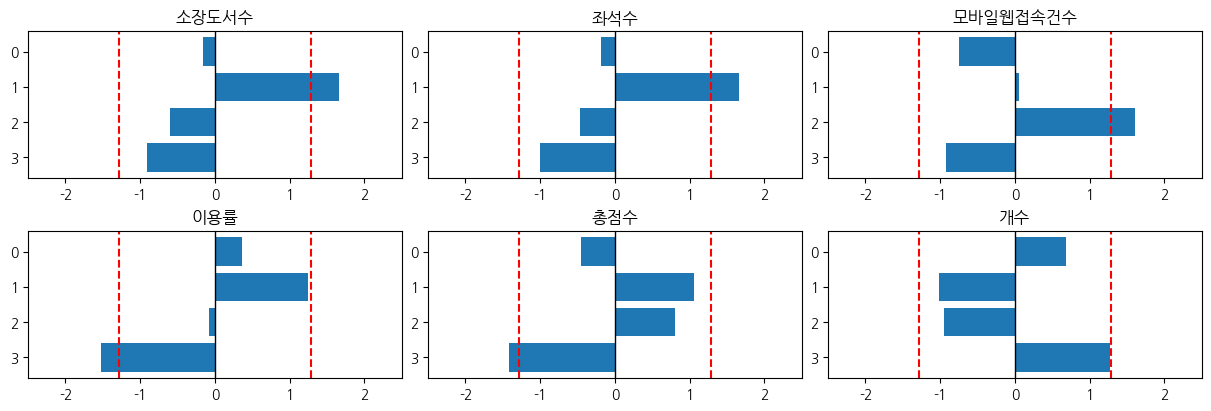

In [71]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 4), constrained_layout=True)
columns = list(clusters_z.columns)

for i in range(2):
    for j in range(3):
        axes[i][j].barh(
            clusters_z.index,
            clusters_z[columns[i * 3 + j]]
        )
        axes[i][j].set_xlim(-2.5, 2.5)
        axes[i][j].axvline(0, color='black', linewidth=1)
        axes[i][j].set_title(f'{columns[i * 3 + j]}')
        axes[i][j].axvline(1.2816, color='red', linestyle='--')
        axes[i][j].axvline(-1.2816, color='red', linestyle='--')
        axes[i][j].invert_yaxis()
        axes[i][j].set_yticks([i for i in range(4)])
plt.show()

---

In [72]:
scaler = StandardScaler()
X = scaler.fit_transform(small_small_df[['총점수']])
kmeans = KMeans(n_clusters=4, random_state=42)
small_small_df['클러스터'] = kmeans.fit_predict(X)
small_small_df

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,소장도서수,좌석수,모바일웹접속건수,이용률,총점수,클러스터
0,119471.500000,336.500000,15275.750000,3.13,2.427248,2
1,47839.666667,128.666667,126758.666667,2.23,-2.519713,3
2,95042.000000,264.000000,130896.000000,5.20,0.341706,1
3,114714.666667,122.333333,32694.000000,4.14,0.046001,1
4,93744.000000,199.333333,95113.000000,5.29,0.031279,1
...,...,...,...,...,...,...
224,106233.500000,132.000000,10353.000000,2.23,0.181869,1
225,62442.500000,268.000000,10410.000000,7.14,-2.036610,3
226,72279.250000,202.500000,316278.000000,4.04,-0.907267,1
227,109897.526316,163.526316,38474.421053,1.56,1.233375,1


In [73]:
clusters = pd.concat([
    small_small_df.groupby('클러스터').mean(),
    small_small_df.groupby('클러스터').count()[['총점수']].rename(columns={'총점수': '개수'})
], axis=1)

clusters_z = zscore(clusters)
clusters_z

,소장도서수,좌석수,모바일웹접속건수,이용률,총점수,개수
클러스터,,,,,,
0,1.215968,0.129031,1.534795,1.706081,1.612018,-1.249064
1,-0.386586,0.422915,-0.542631,-0.710479,-0.547197,1.439277
2,0.592294,1.075355,0.158807,-0.286975,-0.015182,-0.513575
3,-1.421676,-1.627300,-1.150971,-0.708628,-1.049639,0.323362


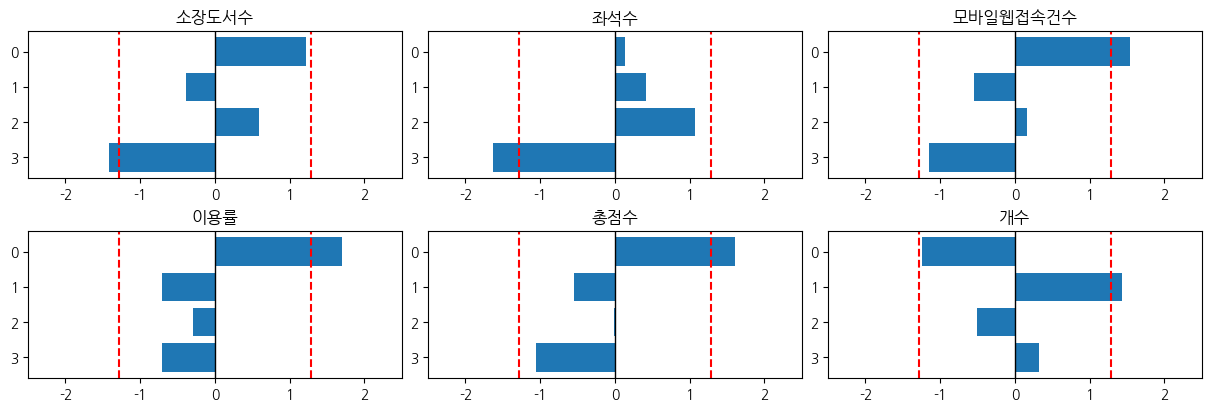

In [74]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 4), constrained_layout=True)
columns = list(clusters_z.columns)

for i in range(2):
    for j in range(3):
        axes[i][j].barh(
            clusters_z.index,
            clusters_z[columns[i * 3 + j]]
        )
        axes[i][j].set_xlim(-2.5, 2.5)
        axes[i][j].axvline(0, color='black', linewidth=1)
        axes[i][j].set_title(f'{columns[i * 3 + j]}')
        axes[i][j].axvline(1.2816, color='red', linestyle='--')
        axes[i][j].axvline(-1.2816, color='red', linestyle='--')
        axes[i][j].invert_yaxis()
        axes[i][j].set_yticks([i for i in range(4)])
plt.show()